# Pre read notes:

1.   Keras in Tensforflow on Google colab (GC) has been used for this exercise.
2.   Since the tensforflow on GC was having older version it was updated to version 2.0 for this exercise.
3. Since the model running time is on the higher side ( even on GPU), multiple iterations / simulations with different hyperparameter options was not done. Only 2 such variants attempted.
4.In most of the cases , the base code given as part of the assignment is used. Wherever it is updated appropriate comment has been provided.



# Load necessary libraries

In [0]:
# Checking the version of tensorflow

import tensorflow as tf
print(tf.__version__)

1.15.0


In [0]:
# Since the Tensorflow version on Google Colab is not version 2.0, we will upgrade to version 2.0 before running the models
!pip uninstall tensorflow

Uninstalling tensorflow-1.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.15.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0


In [0]:
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 34kB/s 
     |████████████████████████████████| 450kB 60.9MB/s 
     |████████████████████████████████| 3.8MB 45.1MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [0]:
# import necessary packages

import os 
import cv2
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import numpy as np
import tensorflow as tf
print ('Tensorflow version:',tf.__version__)
from sklearn.utils import shuffle
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, Conv2D, UpSampling2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon,clear_session
from tensorflow import random

Tensorflow version: 2.0.0


# Set up Colab drive and directory path

In [0]:
# mounting the drive on Google Colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Change current working directory to project folder

In [0]:
# changing the directory to point to project folder.The source data file is loaded to this directory on the drive

os.chdir('/content/drive/My Drive/AIML/Projects/FD')

# Load Data and Analyze results

**Load the "images.npy" file**

In [0]:
# since the images file was given in .npy format we will use numpy load method to load the file

data = np.load('images.npy',allow_pickle=True)

**Analyze the data**

In [0]:
# check the data type and the basic shape

print (type(data))
print(data.shape)

<class 'numpy.ndarray'>
(409, 2)




1. From above it can be observed that there are 409 line items of data with 2 
columns.
2. We will check each of the column/ format etc by taking 2 records from the above.
3. Note that there is only data file and not separate files for training/testing. Hence we will need to do train/test split on this data set 


In [0]:
#check the 1st column for the first 2 rows of data

#check the record in row index 0 and column index 0
data[0,0]

array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)

In [0]:
#check the record in row index 1 and column index 0
data[1,0]

array([[[207, 216, 227, 255],
        [206, 216, 227, 255],
        [207, 216, 227, 255],
        ...,
        [ 35,  33,  34, 255],
        [ 35,  33,  34, 255],
        [ 35,  33,  34, 255]],

       [[207, 216, 227, 255],
        [207, 216, 227, 255],
        [207, 216, 227, 255],
        ...,
        [ 35,  32,  33, 255],
        [ 35,  33,  34, 255],
        [ 35,  33,  34, 255]],

       [[207, 216, 227, 255],
        [207, 216, 227, 255],
        [207, 215, 227, 255],
        ...,
        [ 35,  33,  33, 255],
        [ 35,  33,  34, 255],
        [ 35,  33,  34, 255]],

       ...,

       [[ 31,  21,  17, 255],
        [ 31,  22,  18, 255],
        [ 31,  22,  18, 255],
        ...,
        [  0,   1,   4, 255],
        [  0,   1,   4, 255],
        [  0,   1,   4, 255]],

       [[ 31,  22,  18, 255],
        [ 31,  22,  18, 255],
        [ 31,  22,  18, 255],
        ...,
        [  0,   1,   4, 255],
        [  0,   1,   4, 255],
        [  0,   1,   4, 255]],

       [[ 31

In [0]:
#check the 2nd column for the first 2 rows of data

#check the record in row index 0 and column index 1
data[0,1]

[{'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}]},
 {'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}]}]

In [0]:
#check the record in row index 1 and column index 1
data[1,1]

[{'imageHeight': 697,
  'imageWidth': 1280,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.7053087757313109, 'y': 0.23260437375745527},
   {'x': 0.7692307692307693, 'y': 0.36182902584493043}]}]

Following can be observed from above:

1. The data file contains images in array format ( in first column) and not the path to the image.
2. The 2nd column contains details of image dimensions,label and bounding box coordinates.
1. The images are of different dimensions and not consistent across the dataset.
2. The images are of mixure of images with single face bounding box and images with multiple faces/bounding boxes.
1. Images are color images with RGB channel.
2. For the 2nd column, if there are multiple faces covered, the list has image dimension ,label duplicated though they are the same for that image record. What varies is only the bounding box coordinates.








**Check 2 samples from the loaded "images.npy" file**

In [0]:
# select sample images to be displayed

nlist=[10,4]


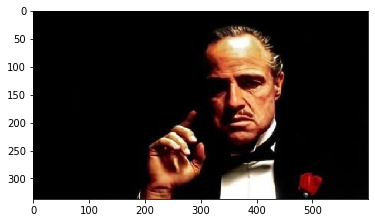

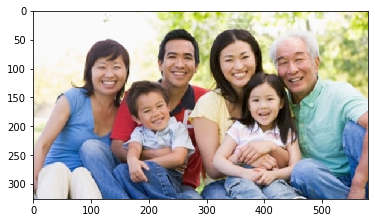

In [0]:
# display the sample images without bounding boxes

for n in nlist:
  fig,ax = plt.subplots(1)
  ax.imshow(data[n,0])
  plt.show()

In [0]:
# create separate array for images and bounding boxes(mask)

image_array= data[:,0]
mask_array = data[:,1]

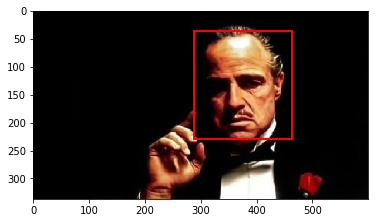

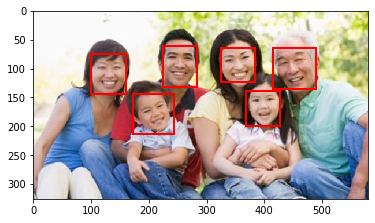

In [0]:
# display sample images with bounding boxes

for n in nlist:
  fig,ax = plt.subplots(1)
  ax.imshow(image_array[n])

  # since the mask array has more than one bounding box per image, the code is looped through for each box coordinates.
  # the coordinate values given is multipled with the image dimension to derive the coordiate to draw as rectange patches.

  nf = len(mask_array[n])
  nf_list = np.arange(1,nf+1)
  for f in nf_list:
    x0=mask_array[n][f-1].get('points')[0].get('x')*mask_array[n][f-1].get('imageWidth')
    y0=mask_array[n][f-1].get('points')[0].get('y')*mask_array[n][f-1].get('imageHeight')
    x1=mask_array[n][f-1].get('points')[1].get('x')*mask_array[n][f-1].get('imageWidth')
    y1=mask_array[n][f-1].get('points')[1].get('y')*mask_array[n][f-1].get('imageHeight')
    rect=patches.Rectangle((x0,y0),x1-x0,y1-y0,linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
  plt.show()

# Preprocessing

**Set image dimensions**

In [0]:
#since the images given are not of uniform dimension, we will need to standardize the image dimension to be fed in to the model

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

**Create features and labels**

In [0]:
# mask array and features array is initialized with zeros for the image dimension set above, with 3 channels for the features. 
# mask dimension may also be considered different (scaled down from the original feature image dimensione.e.g 28*28) but the same dimension as image (224*224) is retained in this case.
# images looped through from the data is resized using cv2 library and captured in features array after running preprocess method
# mask array is created by populating the coordinate bounding boxes area with 1 ( rest of the value is already initialized with 0)

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
features = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    features[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

**Print the shape of features and masks array**

In [0]:
# check the shape of feature array after preprocessing

print(features.shape)

(409, 224, 224, 3)


There are 409 rows of images of dimesion 224*224 in 3 channels

In [0]:
# check the shape of masks array after preprocessing

print(masks.shape)

(409, 224, 224)


There are 409 rows of masks of dimesion 224*224 

**Print a sample image and image array**

In [0]:
n=4  # selecting the image index number to analyze
print(features[n])

[[[ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  ...
  [ 0.59215689  0.68627453 -0.08235294]
  [ 0.49019611  0.57647061 -0.17647058]
  [ 0.51372552  0.60784316 -0.13725489]]

 [[ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  ...
  [ 0.66274512  0.74117649 -0.01960784]
  [ 0.54509807  0.64705884 -0.13725489]
  [ 0.47450984  0.56862748 -0.23921567]]

 [[ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  ...
  [ 0.7647059   0.82745099  0.05098045]
  [ 0.58431375  0.67058825 -0.17647058]
  [ 0.34901965  0.45098042 -0.48235291]]

 ...

 [[ 0.34901965  0.34901965  0.41960788]
  [ 0.52941179  0.52941179  0.60784316]
  [ 0.28627455  0.28627455  0.34901965]
  ...
  [ 0.14509809 -0.10588235 -0.09803921]
  [-0.69411767 -0.62352943 -0.4588235 ]
  [-0.89019608 -0.74117649 -0.46666664]]

 [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


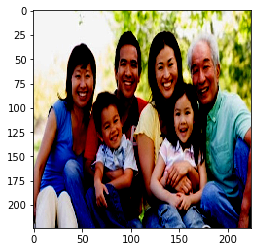

In [0]:
# print the sample image

plt.imshow(features[n])
plt.show()

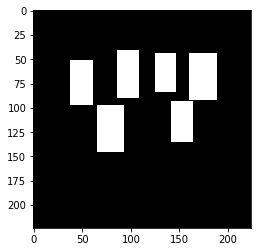

In [0]:
# print the mask for the sample image

plt.imshow(masks[n], cmap='gray')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


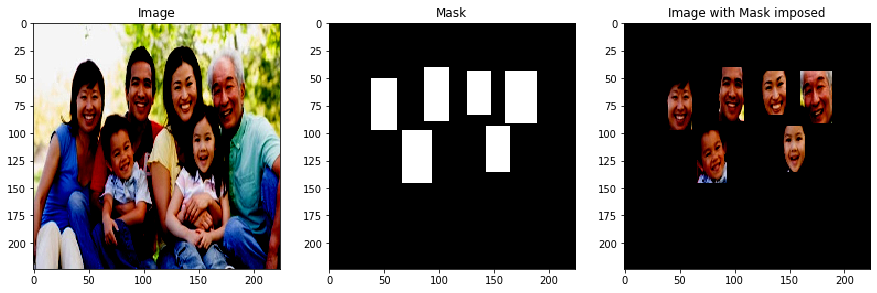

In [0]:
# impose mask on the sample image
# since there are 3 channels in feature, the mask is resized to 1 channel array and feature vector is multiplied for every channel with the mask vector values

mask1 = np.array(masks[n])
mask1_r = mask1.reshape(224,224,1)
for i in range(mask1_r.shape[2]):
  img_mask = np.array(features[n])
  for j in range (img_mask.shape[2]):
    img_mask[:,:,j] = img_mask[:,:,j] * mask1_r[:,:,i]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
ax1.imshow(features[n])
ax1.set_title('Image')
ax2.set_title('Mask')
ax3.set_title('Image with Mask imposed')
ax2.imshow(masks[n], cmap='gray')
ax3.imshow(img_mask)
plt.show()

**Train and Test split**

In [0]:
# 70% of the data set is used for training and rest for testing

train_ratio=.70
seed = 9

features, masks = shuffle(features, masks, random_state=seed)

train_end = int(train_ratio * len(masks))

train_features = np.array(features[:train_end])
test_features = np.array(features[train_end:])

train_masks = np.array(masks[:train_end])
test_masks = np.array(masks[train_end:])

X_train, X_test = np.array(train_features), np.array(test_features)
y_train, y_test = np.array(train_masks), np.array(test_masks)


In [0]:
# print the train and test dimensions for X and y
 
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(286, 224, 224, 3)
(123, 224, 224, 3)
(286, 224, 224)
(123, 224, 224)


# Create the model

In [0]:
# settings for model creation
# we are using the input size as 224*224 and Imagenet weights to invoke MobileNet model

ALPHA = 1 
HEIGHT_CELLS = 224
WIDTH_CELLS = 224
WEIGHTS = 'imagenet'

In [0]:
# function to create the CNN model

def create_model(trainable=True):

    seed=9 
    np.random.seed(seed)
    random.set_seed(seed)

    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights=WEIGHTS)

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_1_relu").output
    block2 = model.get_layer("conv_pw_3_relu").output
    block3 = model.get_layer("conv_pw_5_relu").output
    block4 = model.get_layer("conv_pw_11_relu").output
    block5 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block5), block4])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x= UpSampling2D()(x)

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((HEIGHT_CELLS, WIDTH_CELLS))(x)

    return Model(inputs=model.input, outputs=x)

1.   MobileNet model is used as Transfer learning approach for creating the CNN model.
2.   Model is fed with image size 224 * 224 as input for MobileNet.
1.   Except the classification /FC layer rest of the layers are loaded as non trainable.
2.   Additional layers are then added as based on Unet principle.
1.   Since the MobileNet output is 7 * 7, the model output is captured and then upsampled(Unet approach) to generate the output at 224 * 224 dimension ( the dimension for the mask)
2.   Hence the blocks are created to capture the layer at respective resolution output, to be then concatenated during upsampling.
1.   Block5 captures the model output created at conv_pw_13_relu with size 7*7. This is then upsampled to 14 * 14 and then concatenated with block4 output (conv_pw_11_relu) which is of size 14 * 14.
2.   This 14 * 14 output is then upsampled to 28 * 28 and then concatenated with block 3 output (conv_pw_5_relu) which is of size 28 * 28.
1.   This 28 * 28 output is then upsampled to 56 * 56 and then concatenated with block 2 output (conv_pw_3_relu) which is of size 56 * 56.
2.   This 56 * 56 output is then upsampled to 112 * 112 and then concatenated with block 1 output (conv_pw_1_relu) which is of size 112 * 112.
1.   This 112 * 112 output is then upsampled to 224 * 224 to match the mask size. This output is then sent through convolution layer with sigmoid activation which is then reshaped to 224*224 to get the output in line with mask size
















**Call the create_model function**

In [0]:
# create model and check summary

clear_session()
model = create_model(False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
______________________________________________________________________________________________

Based on the Unet upsampling & concatenating approach the number of traineable parameters  is 1985. With each layer of concatenation added ( as part of Unet) we can observe the increase in the number of features ( which is basically the features added from the block output as explained in detail in previous step).

In [0]:
# printing the trainable flag for the layers

for layer in model.layers:
  print(layer.name, ', Trainable:', layer.trainable)

input_1 , Trainable: False
conv1_pad , Trainable: False
conv1 , Trainable: False
conv1_bn , Trainable: False
conv1_relu , Trainable: False
conv_dw_1 , Trainable: False
conv_dw_1_bn , Trainable: False
conv_dw_1_relu , Trainable: False
conv_pw_1 , Trainable: False
conv_pw_1_bn , Trainable: False
conv_pw_1_relu , Trainable: False
conv_pad_2 , Trainable: False
conv_dw_2 , Trainable: False
conv_dw_2_bn , Trainable: False
conv_dw_2_relu , Trainable: False
conv_pw_2 , Trainable: False
conv_pw_2_bn , Trainable: False
conv_pw_2_relu , Trainable: False
conv_dw_3 , Trainable: False
conv_dw_3_bn , Trainable: False
conv_dw_3_relu , Trainable: False
conv_pw_3 , Trainable: False
conv_pw_3_bn , Trainable: False
conv_pw_3_relu , Trainable: False
conv_pad_4 , Trainable: False
conv_dw_4 , Trainable: False
conv_dw_4_bn , Trainable: False
conv_dw_4_relu , Trainable: False
conv_pw_4 , Trainable: False
conv_pw_4_bn , Trainable: False
conv_pw_4_relu , Trainable: False
conv_dw_5 , Trainable: False
conv_dw_5_bn

As seen above only the layers added are taken as trainable and the base MobileNet layers imported are considered trainable false and the weights as imported will be re-used for these layers. 

**Define dice coefficient function**

In [0]:
# creating dice coefficient function

def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + epsilon())

**Define loss function**

In [0]:
# creating loss function

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

# Compile and Fit Model

There are 2 variants computed here.

1. Variant 1: optimizer,batchsize,patience,callback parameters retained as same as given in assignment base solution notebook for 25 epoch.
2. Variant 2: optimizer,batchsize,patience,callback parameters changed to evaluate different results for 100 epoch.
1. The filename for model save , as part of modelcheckpoint, is not suffixed with loss/dice values as there are too many files that get generated when the model runs. Hence for each variant model weights are captured with only 1 file name suffixed with variant.
2. The model weights are captured in separate files 'mymodelwt_A' and 'mymodelwt_B' respectively.







In [0]:
# Variant1 - settings

EPOCHS = 25
BATCH_SIZE = 1
PATIENCE = 5
FILENAME='mymodelwt_A.h5'

# optimizer is Adam with metrics as dice coefficient and loss as loss function as setup above

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

# model checkpoint is set up based on training loss and early stop is also based on training loss for patience as 5 epochs
# LR reduction is also based on training loss

checkpoint = ModelCheckpoint(FILENAME, monitor="loss", verbose=1, save_best_only=True,save_weights_only=True, mode="min",  save_freq='epoch')
stop = EarlyStopping(monitor="loss", patience=PATIENCE, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=PATIENCE, min_lr=1e-6, verbose=1, mode="min")

start_time=time.time()
model.fit(X_train, y_train,validation_data=(X_test,y_test),epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=2,callbacks=[stop,checkpoint,reduce_lr])
et=round(time.time()-start_time,2)
print()
print('Model fit for model variant A completed in',et, 'seconds')

Train on 286 samples, validate on 123 samples
Epoch 1/25

Epoch 00001: loss improved from inf to 2.23351, saving model to mymodelwt_A.h5
286/286 - 170s - loss: 2.2335 - dice_coefficient: 0.2429 - val_loss: 1.9137 - val_dice_coefficient: 0.2577
Epoch 2/25

Epoch 00002: loss improved from 2.23351 to 1.59169, saving model to mymodelwt_A.h5
286/286 - 169s - loss: 1.5917 - dice_coefficient: 0.3475 - val_loss: 1.5552 - val_dice_coefficient: 0.3434
Epoch 3/25

Epoch 00003: loss improved from 1.59169 to 1.41339, saving model to mymodelwt_A.h5
286/286 - 170s - loss: 1.4134 - dice_coefficient: 0.3977 - val_loss: 1.3484 - val_dice_coefficient: 0.3892
Epoch 4/25

Epoch 00004: loss improved from 1.41339 to 1.31185, saving model to mymodelwt_A.h5
286/286 - 173s - loss: 1.3118 - dice_coefficient: 0.4285 - val_loss: 1.2518 - val_dice_coefficient: 0.4187
Epoch 5/25

Epoch 00005: loss improved from 1.31185 to 1.24757, saving model to mymodelwt_A.h5
286/286 - 173s - loss: 1.2476 - dice_coefficient: 0.449

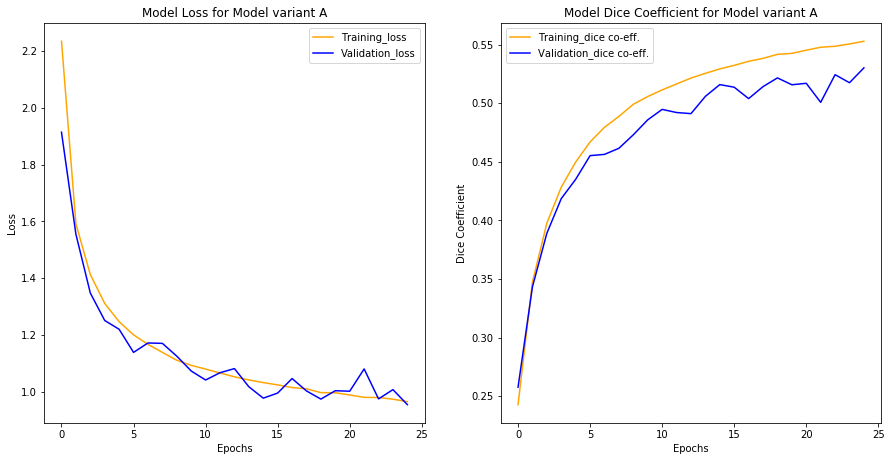

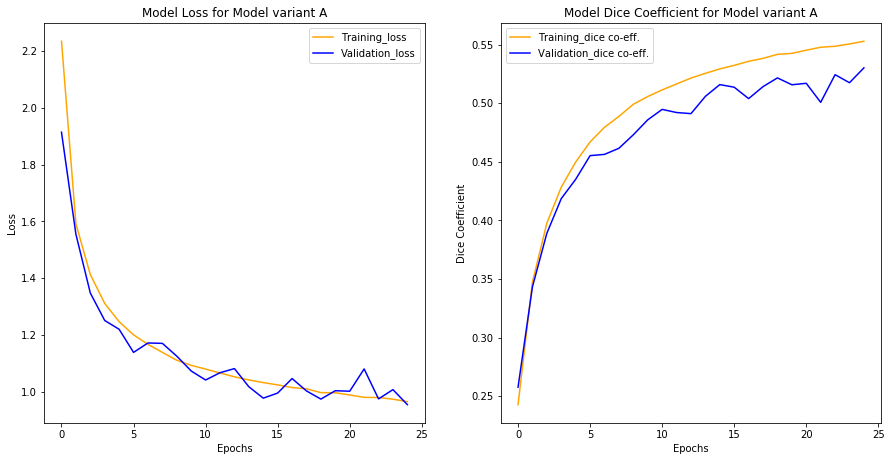

In [0]:
# printing the graph to visualize the loss and dice coefficient movement in training and test epoch runs

train_loss=val_loss=train_dc=val_dc=None
train_loss = model.history.history['loss']
val_loss   = model.history.history['val_loss']
train_dc  = model.history.history['dice_coefficient']
val_dc    = model.history.history['val_dice_coefficient']


figure_obj = plt.figure(figsize = (15,25))
epochs = range(0, len(train_loss))
ax1 = figure_obj.add_subplot(3,2,1)   
ax1.plot(epochs, train_loss, label='Training_loss', color = 'orange')
ax1.plot(epochs, val_loss, label='Validation_loss', color = 'blue')
ax1.legend(loc='best')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.title.set_text('Model Loss for Model variant A')

ax2 = figure_obj.add_subplot(3,2,2)
ax2.plot(epochs, train_dc, label='Training_dice co-eff.', color = 'orange')
ax2.plot(epochs, val_dc, label='Validation_dice co-eff.', color = 'blue')
ax2.legend(loc='best')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Dice Coefficient")
ax2.title.set_text('Model Dice Coefficient for Model variant A')  

1.   While the movement in traning loss / training dice coefficient is smooth, test data values do not seem to move smoothly. There are many highs and lows.
2.   After 10 epoch the improvement in test measures is not significant.
3.   After 25 epoch the validation dice co-efficient could reach only 0.53



Variant 2:

In [0]:
# in this variant we increase the batch size to 12, number of epoch to 100 and patience to 20

clear_session()
model = create_model(False)

EPOCHS = 100
BATCH_SIZE = 12
PATIENCE = 20
FILENAME='mymodelwt_B.h5'


# in optimizer parameters amsgrad is set to True to check if this improves convergence

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])


# model checkpoint is done based on validation dice coefficient (max mode) while early stopping is done based on validation loss (min mode)
# LR reduction is also monitored based on validation loss
# none of these parameters are based on training data

checkpoint = ModelCheckpoint(FILENAME, monitor="val_dice_coefficient", verbose=1, save_best_only=True,save_weights_only=True, mode="max", save_freq='epoch')
stop = EarlyStopping(monitor="val_loss", patience=PATIENCE, mode="min",min_delta=.01)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=PATIENCE, min_lr=1e-6, verbose=0, mode="min")

start_time=time.time()
model.fit(X_train, y_train,validation_data=(X_test,y_test),epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=2,callbacks=[stop,checkpoint,reduce_lr])
et=round(time.time()-start_time,2)
print()
print('Model fit for model variant B completed in',et, 'seconds')

Train on 286 samples, validate on 123 samples
Epoch 1/100

Epoch 00001: val_dice_coefficient improved from -inf to 0.13286, saving model to mymodelwt_B.h5
286/286 - 150s - loss: 2.5251 - dice_coefficient: 0.1901 - val_loss: 2.6558 - val_dice_coefficient: 0.1329
Epoch 2/100

Epoch 00002: val_dice_coefficient improved from 0.13286 to 0.16685, saving model to mymodelwt_B.h5
286/286 - 145s - loss: 2.1732 - dice_coefficient: 0.2121 - val_loss: 2.3625 - val_dice_coefficient: 0.1669
Epoch 3/100

Epoch 00003: val_dice_coefficient improved from 0.16685 to 0.19625, saving model to mymodelwt_B.h5
286/286 - 144s - loss: 1.9160 - dice_coefficient: 0.2547 - val_loss: 2.1434 - val_dice_coefficient: 0.1962
Epoch 4/100

Epoch 00004: val_dice_coefficient improved from 0.19625 to 0.22925, saving model to mymodelwt_B.h5
286/286 - 143s - loss: 1.7567 - dice_coefficient: 0.2823 - val_loss: 1.9486 - val_dice_coefficient: 0.2293
Epoch 5/100

Epoch 00005: val_dice_coefficient improved from 0.22925 to 0.25930, 

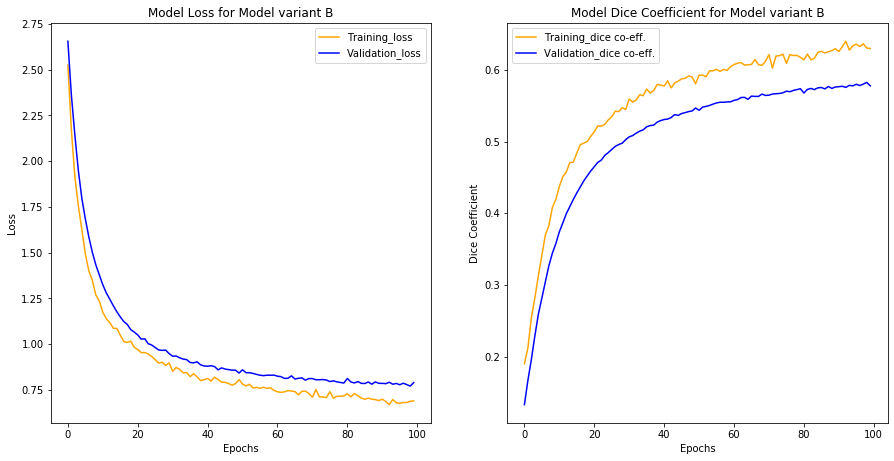

In [0]:
# printing the graph to visualize the loss and dice coefficient movement in training and test epoch runs

train_loss=val_loss=train_dc=val_dc=None
train_loss = model.history.history['loss']
val_loss   = model.history.history['val_loss']
train_dc  = model.history.history['dice_coefficient']
val_dc    = model.history.history['val_dice_coefficient']


figure_obj = plt.figure(figsize = (15,25))
epochs = range(0, len(train_loss))
ax1 = figure_obj.add_subplot(3,2,1)   
ax1.plot(epochs, train_loss, label='Training_loss', color = 'orange')
ax1.plot(epochs, val_loss, label='Validation_loss', color = 'blue')
ax1.legend(loc='best')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.title.set_text('Model Loss for Model variant B')

ax2 = figure_obj.add_subplot(3,2,2)
ax2.plot(epochs, train_dc, label='Training_dice co-eff.', color = 'orange')
ax2.plot(epochs, val_dc, label='Validation_dice co-eff.', color = 'blue')
ax2.legend(loc='best')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Dice Coefficient")
ax2.title.set_text('Model Dice Coefficient for Model variant B')  


1.   The curve for loss as well as dice coefficient is comparatively smooth for both training and test data sets.
2.   After around 40 epoch the rate at which the improvement happens is relatively slower.
1.   After 100 epoch the model could achieve dice coefficient of 0.58
2.   Since the calculation runs longer additional epochs / parameter tuning is not attempted.





In [0]:
# since variant B gives better metrics value , we take this model and weight to predict the mask for any sample dataset

BESTMODELWTFILE = 'mymodelwt_B.h5'
clear_session()
model = create_model()
model.load_weights(BESTMODELWTFILE)

# Model Prediction

**For a selected sample image check the actual mask and predicted mask**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


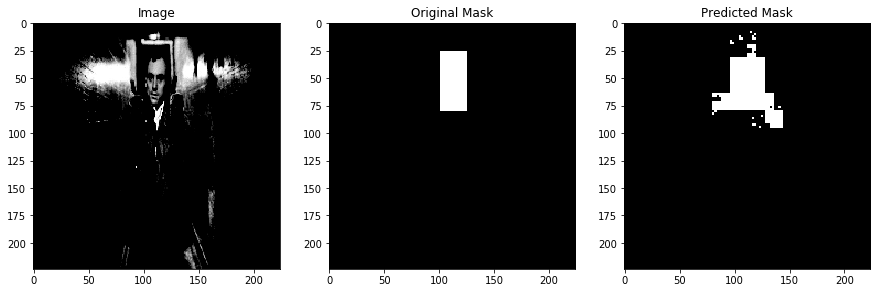

In [0]:
# Mask is predicted for sample image 22 in the test dataset
# Since the mask size and model output size is the same there is no need to resize


n = 22
sample_image = X_test[n]
sample_mask = y_test[n]
pred_mask = 1.0*(model.predict(x=np.array([X_test[n]]))[0] > 0.5)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
ax1.imshow(sample_image)
ax1.set_title('Image')
ax2.set_title('Original Mask')
ax3.set_title('Predicted Mask')
ax2.imshow(sample_mask, cmap='gray')
ax3.imshow(pred_mask, cmap='gray')
plt.show()

We can see from above that the prediction is more or less close to the actual mask eventhough there is some noise in the predicted mask

**For the selected sample image impose the predicted mask and compare with original mask**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


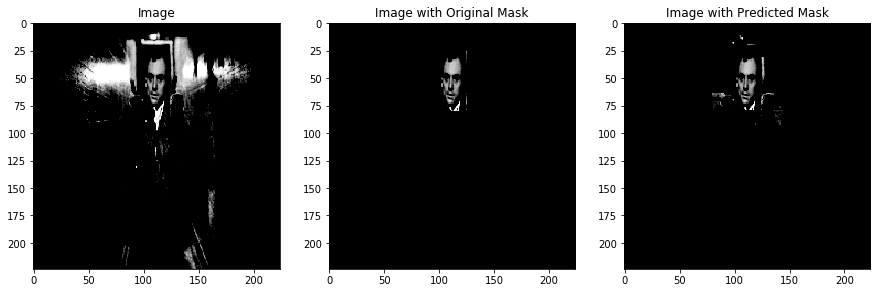

In [0]:
# since there are 3 channels in feature, the mask is resized to 1 channel array and feature vector is multiplied for every channel with the mask vector values

mask1_r = sample_mask.reshape(224,224,1)
for i in range(mask1_r.shape[2]):
  img_mask = np.array(X_test[n])
  for j in range (img_mask.shape[2]):
    img_mask[:,:,j] = img_mask[:,:,j] * mask1_r[:,:,i]

mask2_r = pred_mask.reshape(224,224,1)
for i in range(mask2_r.shape[2]):
  img_mask_pred = np.array(X_test[n])
  for j in range (img_mask_pred.shape[2]):
    img_mask_pred[:,:,j] = img_mask_pred[:,:,j] * mask2_r[:,:,i]    

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
ax1.imshow(sample_image)
ax1.set_title('Image')
ax2.set_title('Image with Original Mask')
ax3.set_title('Image with Predicted Mask')
ax2.imshow(img_mask, cmap='gray')
ax3.imshow(img_mask_pred)
plt.show()

At 0.58 dice coefficent , the model has managed to predict the mask that is as close to the original mask. While the core central values of the mask has comeout correct, there are additional noises in the prediction.